In [114]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image, ImageFile
import os
import glob
from tqdm import tqdm

# modeling and neural network libs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, plot_confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.metrics import Accuracy, Recall, AUC

In [2]:
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'

In [3]:
train_neg_filepath = 'chest_xray/train/NORMAL/'
train_pos_filepath = 'chest_xray/train/PNEUMONIA/'
test_neg_filepath = 'chest_xray/test/NORMAL/'
test_pos_filepath = 'chest_xray/test/PNEUMONIA/'

In [4]:
files_train_neg = glob.glob(os.path.join(train_neg_filepath,'*.jpeg'))
files_train_pos = glob.glob(os.path.join(train_pos_filepath,'*.jpeg'))
files_test_neg = glob.glob(os.path.join(test_neg_filepath,'*.jpeg'))
files_test_pos = glob.glob(os.path.join(test_pos_filepath,'*.jpeg'))

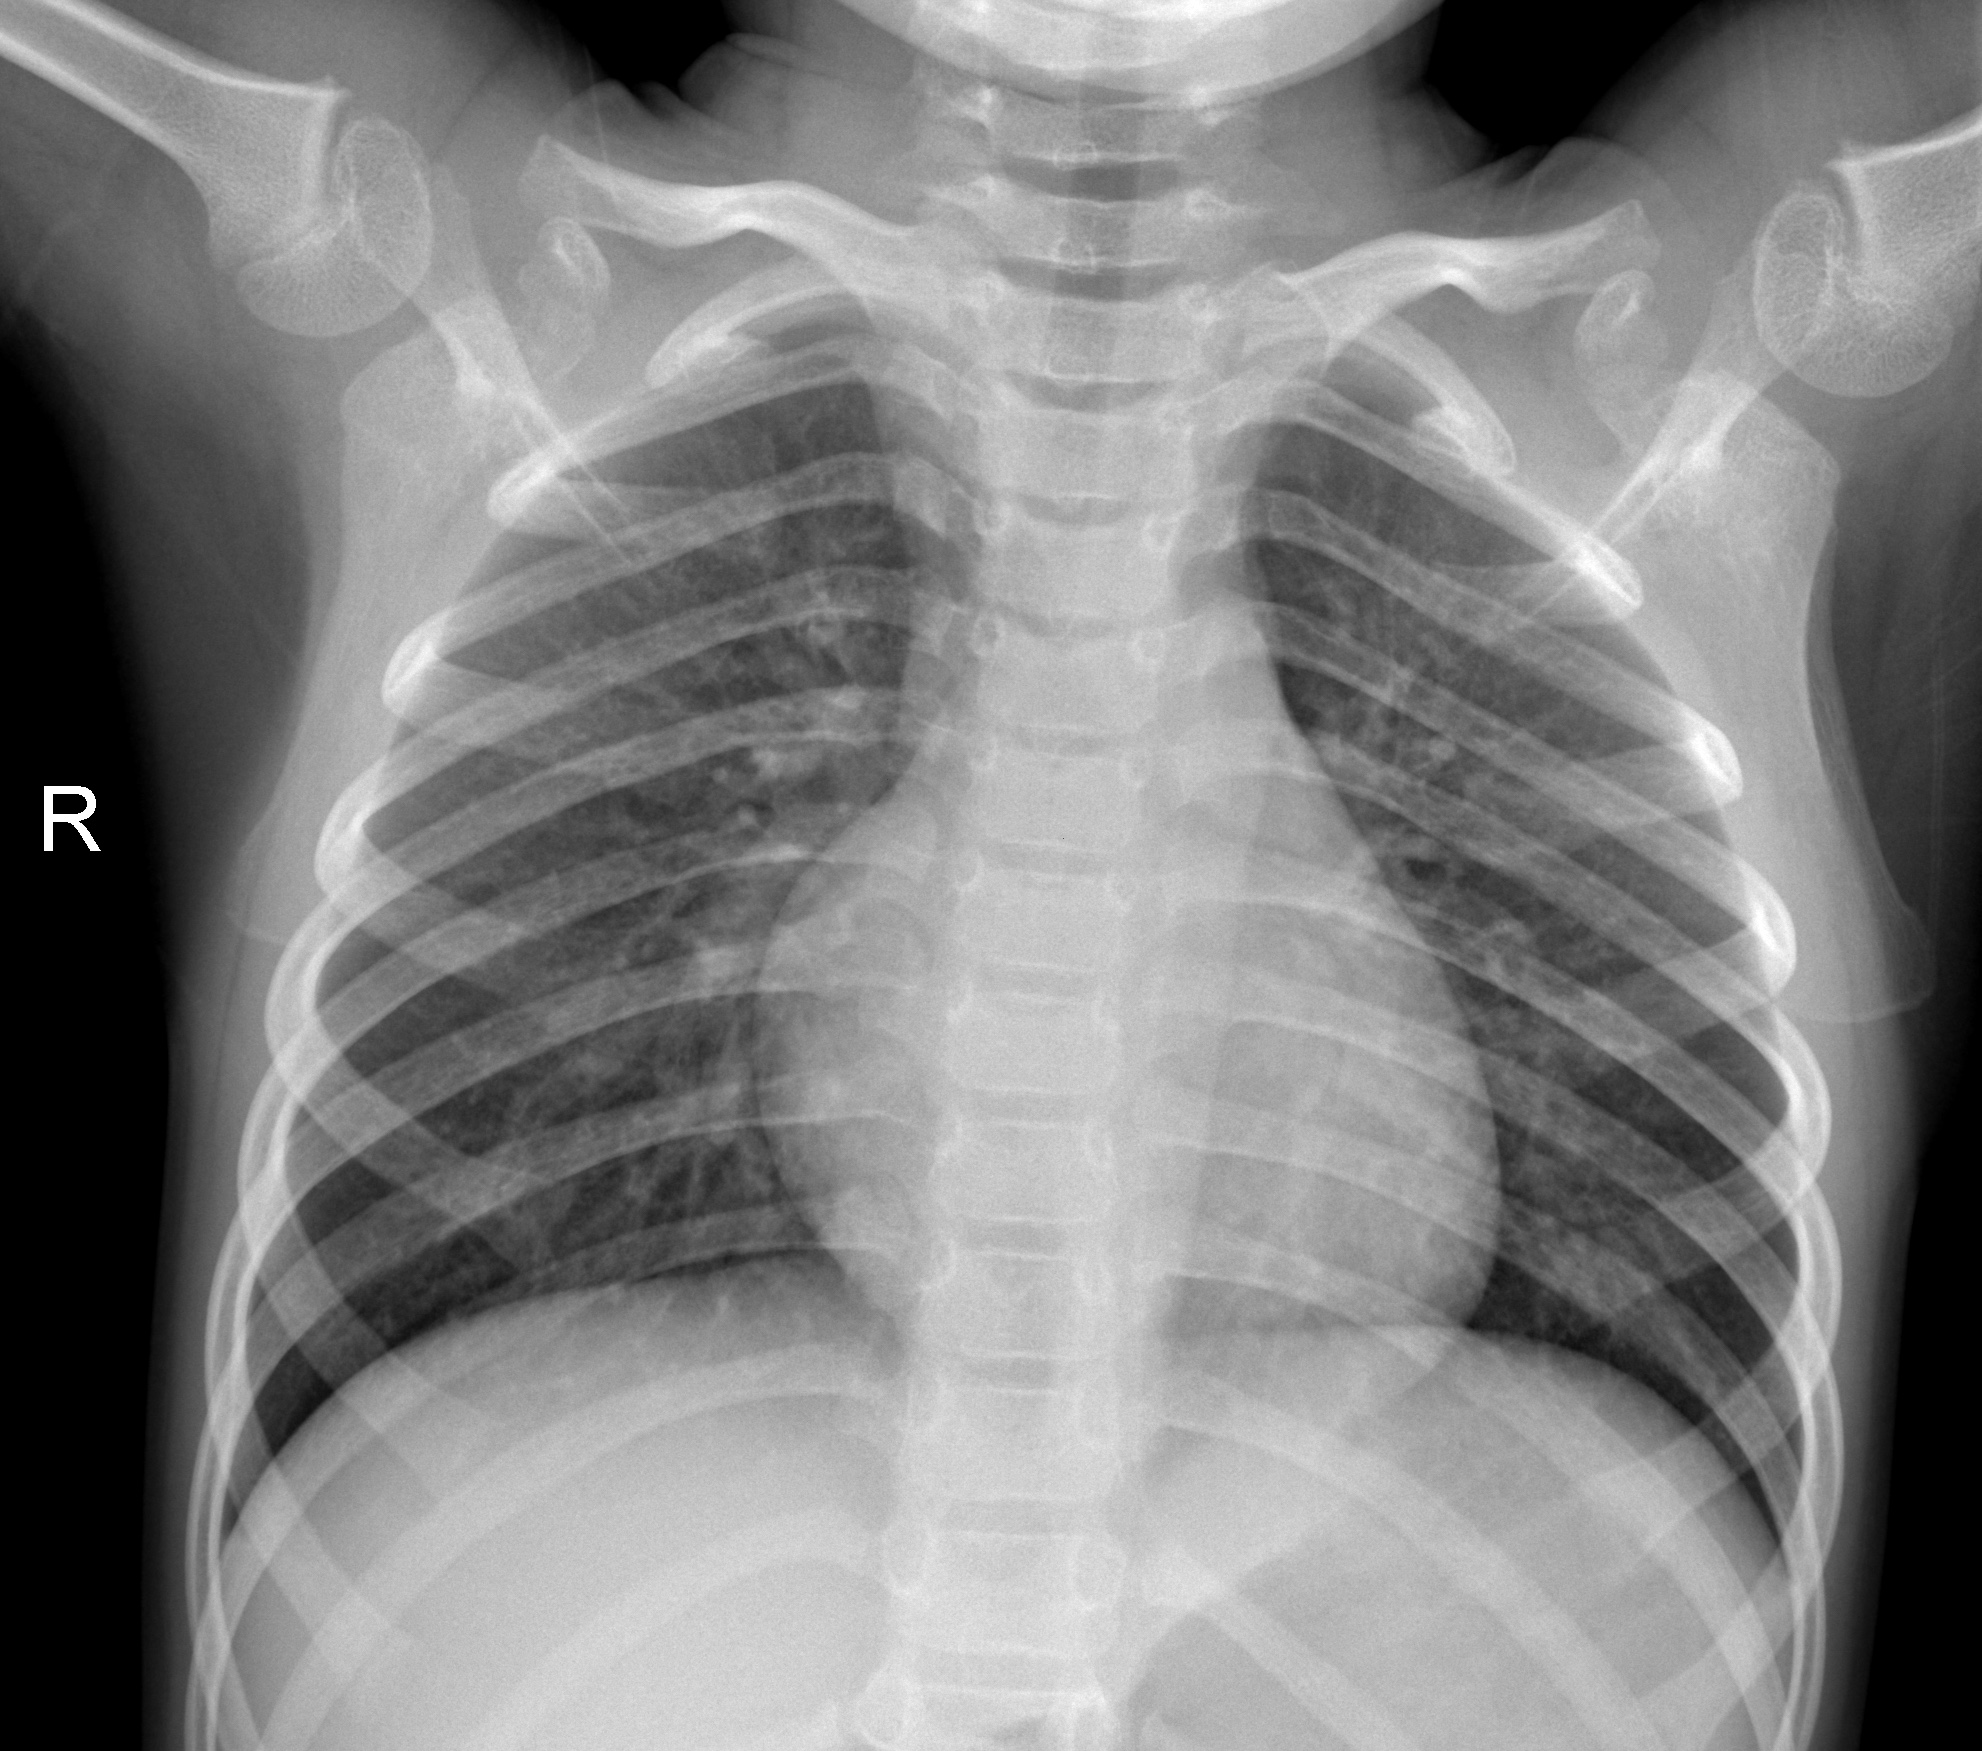

In [74]:
# to do: loop though train nomal/bacteria/viral to show images
success = Image.open(files_train_neg[0])
success.load()
success

In [5]:
def img_to_array_list(filepath):
    arr_list = []
    for img in tqdm(filepath):
        pic = Image.open(img)
        pic.load()
        arr_list.append(np.asarray(pic))
    return arr_list

In [6]:
train_neg = img_to_array_list(files_train_neg)
train_pos = img_to_array_list(files_train_pos)
test_neg = img_to_array_list(files_test_neg)
test_pos = img_to_array_list(files_test_pos)

100%|██████████| 390/390 [00:01<00:00, 268.35it/s]


In [7]:
train_neg

[array([[148, 150, 145, ..., 102, 104, 107],
        [147, 146, 145, ..., 102, 104, 106],
        [144, 145, 147, ..., 105, 107, 109],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 array([[71, 75, 69, ..., 38, 37, 39],
        [74, 74, 69, ..., 38, 36, 37],
        [74, 75, 67, ..., 38, 36, 35],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[ 0, 43, 42, ...,  0,  0,  0],
        [ 0, 43, 41, ...,  0,  0,  0],
        [ 1, 43, 41, ...,  0,  0,  0],
        ...,
        [ 1, 43, 45, ...,  0,  0,  0],
        [ 1, 44, 45, ...,  0,  0,  0],
      

In [8]:
train_list = []
for img in train_neg:
    train_list.append((img, 0))
for img in train_pos:
    train_list.append((img, 1))
train_list = pd.DataFrame(train_list, columns=['img', 'target'])
train_list.head()

,img,target
0,"[[148, 150, 145, 149, 152, 148, 149, 144, 146,...",0
1,"[[71, 75, 69, 67, 65, 64, 66, 66, 68, 66, 64, ...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 43, 42, 38, 31, 24, 18, 13, 6, 3, 0, 0, 0...",0
4,"[[35, 35, 34, 34, 35, 35, 36, 40, 40, 37, 36, ...",0


In [9]:
train_list['img'][0]

array([[148, 150, 145, ..., 102, 104, 107],
       [147, 146, 145, ..., 102, 104, 106],
       [144, 145, 147, ..., 105, 107, 109],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [10]:
train_list['target'].value_counts()

1    3883
0    1348
Name: target, dtype: int64

In [11]:
X = train_list['img']
y = train_list['target']

In [12]:
X.shape

(5231,)

In [13]:
y.unique()

array([0, 1], dtype=int64)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.2)
X_train.shape

(4184,)

## Dummy Model

In [15]:
baseline_model = DummyClassifier(strategy='uniform')
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [16]:
dummy_acc = baseline_model.score(X_train, y_train)
dummy_acc

0.5052581261950286

In [17]:
cross_val_score(baseline_model, X_train, y_train)

array([0.47789725, 0.52329749, 0.51015532, 0.49940263, 0.47727273])

In [18]:
dummy_preds = baseline_model.predict(X_train)

In [19]:
recall_score(y_train, dummy_preds)

0.48976327575175943

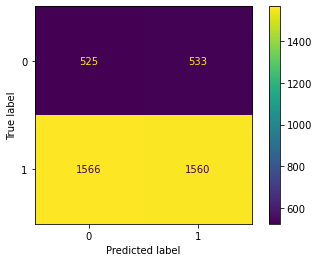

In [20]:
plot_confusion_matrix(baseline_model, X_train, y_train)

In [28]:
# 80/20 split
# batch size=32
img_dgen = ImageDataGenerator(rescale=1./255, validation_split = 0.20)


#training dir
train_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64), color_mode='grayscale',
                                         class_mode='binary', subset='training', seed=42)

validation_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64),color_mode='grayscale',
                                              class_mode='binary', subset='validation', seed=42)

# testing dir
test_set = img_dgen.flow_from_directory(test_path, target_size=(64, 64), color_mode='grayscale',
                                        class_mode='binary', shuffle=False, seed=42)

Found 4186 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Simpe NN

In [47]:
simple_model = Sequential()
simple_model.add(Flatten(input_shape=(64,64,1)))
simple_model.add(Dense(20, activation='relu'))
simple_model.add(Dense(7, activation='relu'))
simple_model.add(Dense(5, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy', Recall(name='recall')])

simple_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                81940     
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [48]:
simple_results = simple_model.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 27s 207ms/step - loss: 0.4279 - accuracy: 0.7936 - recall: 0.9955 - auc: 0.8670 - val_loss: 0.2912 - val_accuracy: 0.8967 - val_recall: 0.9884 - val_auc: 0.9723
Epoch 2/30
131/131 [==============================] - 27s 203ms/step - loss: 0.2880 - accuracy: 0.9047 - recall: 0.9846 - auc: 0.9622 - val_loss: 0.2387 - val_accuracy: 0.9502 - val_recall: 0.9549 - val_auc: 0.9768
Epoch 3/30
131/131 [==============================] - 27s 203ms/step - loss: 0.2289 - accuracy: 0.9338 - recall: 0.9778 - auc: 0.9763 - val_loss: 0.1850 - val_accuracy: 0.9512 - val_recall: 0.9884 - val_auc: 0.9868
Epoch 4/30
131/131 [==============================] - 27s 203ms/step - loss: 0.1873 - accuracy: 0.9408 - recall: 0.9659 - auc: 0.9781 - val_loss: 0.1823 - val_accuracy: 0.9435 - val_recall: 0.9304 - val_auc: 0.9835
Epoch 5/30
131/131 [==============================] - 27s 203ms/step - loss: 0.1701 - accuracy: 0.9451 - recall: 0.9649 - auc: 0.9799 - val_

In [49]:
simple_results.history

{'loss': [0.42790699005126953,
  0.288018137216568,
  0.22889642417430878,
  0.1873343139886856,
  0.170140340924263,
  0.14337937533855438,
  0.14558418095111847,
  0.1296842247247696,
  0.1267733871936798,
  0.1348218470811844,
  0.11720918118953705,
  0.11471207439899445,
  0.11677110940217972,
  0.11766327917575836,
  0.11286953836679459,
  0.09936362504959106,
  0.11872128397226334,
  0.10174713283777237,
  0.10060468316078186,
  0.09293612837791443,
  0.10021679103374481,
  0.09869690239429474,
  0.08917941153049469,
  0.08568122237920761,
  0.08985232561826706,
  0.09530916064977646,
  0.10315444320440292,
  0.08745863288640976,
  0.08518398553133011,
  0.08477330952882767],
 'accuracy': [0.7935976982116699,
  0.9046822786331177,
  0.9338270425796509,
  0.9407548904418945,
  0.9450549483299255,
  0.9524605870246887,
  0.9472049474716187,
  0.9512661099433899,
  0.9543716907501221,
  0.9481605291366577,
  0.9569995403289795,
  0.9577162265777588,
  0.9567606449127197,
  0.9567606

<AxesSubplot:>

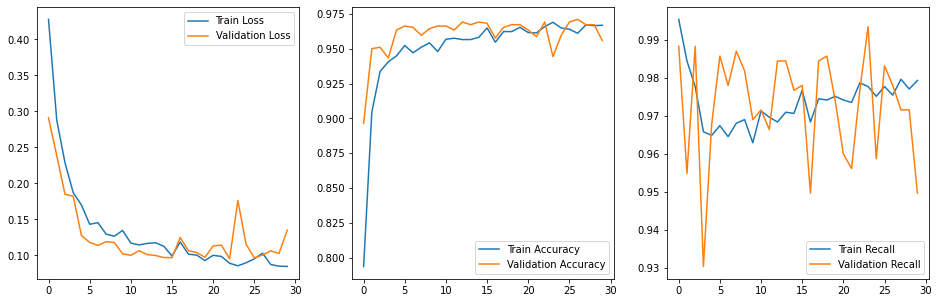

In [68]:
# code sampled from lecture
train_loss = simple_results.history['loss']
train_acc = simple_results.history['accuracy']
train_rec = simple_results.history['recall']
val_loss = simple_results.history['val_loss']
val_acc = simple_results.history['val_accuracy']
val_rec = simple_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=train_rec, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=val_rec, ax=ax3, label='Validation Recall')


In [72]:
simple_model.evaluate(validation_set)

33/33 [==============================] - 5s 151ms/step - loss: 0.1351 - accuracy: 0.9560 - recall: 0.9497 - auc: 0.9884


[0.13513557612895966,
 0.9559808373451233,
 0.9497422575950623,
 0.9883949756622314]

### Data Augmentation

In [101]:
datagen_aug = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.20,
                                   rotation_range=40, 
                                   brightness_range=(0.1,0.9),
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_set2 = datagen_aug.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='training', seed=42)

Found 4186 images belonging to 2 classes.


### Simple w/ augmentation

In [102]:
aug_model = Sequential()
aug_model.add(Flatten(input_shape=(64,64,1)))
aug_model.add(Dense(20, activation='relu'))
aug_model.add(Dense(7, activation='relu'))
aug_model.add(Dense(5, activation='relu'))
aug_model.add(Dense(1, activation='sigmoid'))

aug_model.compile(optimizer='Adam',
             loss='binary_crossentropy',
             metrics=['accuracy', Recall(name='recall')])

aug_results = aug_model.fit(train_set2, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 230ms/step - loss: 0.5748 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5668 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 2/30
131/131 [==============================] - 30s 225ms/step - loss: 0.5638 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5323 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 3/30
131/131 [==============================] - 29s 225ms/step - loss: 0.5580 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4925 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 4/30
131/131 [==============================] - 30s 226ms/step - loss: 0.5495 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4978 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 5/30
131/131 [==============================] - 29s 224ms/step - loss: 0.5476 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4623 - val_accuracy: 0.7426 - val_recall: 1.0000
Epoch 6/30
131/131 [==============================] - 29s 222ms/step - loss: 0.5381 -

In [96]:
aug_model.evaluate(validation_set)

33/33 [==============================] - 5s 152ms/step - loss: 0.3941 - accuracy: 0.8077 - recall: 0.9948 - auc: 0.9279


[0.3941107988357544,
 0.8076555132865906,
 0.9948453903198242,
 0.9278781414031982]

In [ ]:
aug_model.evaluate(tra)

<AxesSubplot:>

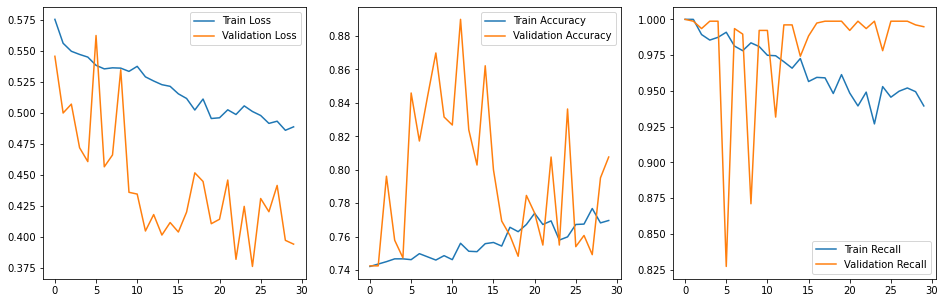

In [75]:
train_loss2 = aug_results.history['loss']
train_acc2 = aug_results.history['accuracy']
train_rec2 = aug_results.history['recall']
val_loss2 = aug_results.history['val_loss']
val_acc2 = aug_results.history['val_accuracy']
val_rec2 = aug_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=train_loss2, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=train_acc2, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=train_rec2, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=val_loss2, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=val_acc2, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=val_rec2, ax=ax3, label='Validation Recall')

## CNN w/ augmentation

In [93]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
              
cnn_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [94]:
# fitting to aug train
cnn_results = cnn_model.fit(train_set2, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 229ms/step - loss: 0.5443 - accuracy: 0.7382 - recall: 0.9491 - val_loss: 0.4563 - val_accuracy: 0.8459 - val_recall: 0.8866
Epoch 2/30
131/131 [==============================] - 29s 224ms/step - loss: 0.4145 - accuracy: 0.8010 - recall: 0.9179 - val_loss: 0.2666 - val_accuracy: 0.8880 - val_recall: 0.8840
Epoch 3/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3583 - accuracy: 0.8318 - recall: 0.9083 - val_loss: 0.3341 - val_accuracy: 0.8593 - val_recall: 0.8157
Epoch 4/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3464 - accuracy: 0.8366 - recall: 0.9038 - val_loss: 0.2484 - val_accuracy: 0.9033 - val_recall: 0.8943
Epoch 5/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3412 - accuracy: 0.8416 - recall: 0.9108 - val_loss: 0.2183 - val_accuracy: 0.9129 - val_recall: 0.9021
Epoch 6/30
131/131 [==============================] - 29s 224ms/step - loss: 0.3153 -

In [97]:
cnn_model.evaluate(validation_set)

33/33 [==============================] - 5s 154ms/step - loss: 0.2300 - accuracy: 0.9120 - recall: 0.8969


[0.22997871041297913, 0.9119617342948914, 0.8969072103500366]

<AxesSubplot:>

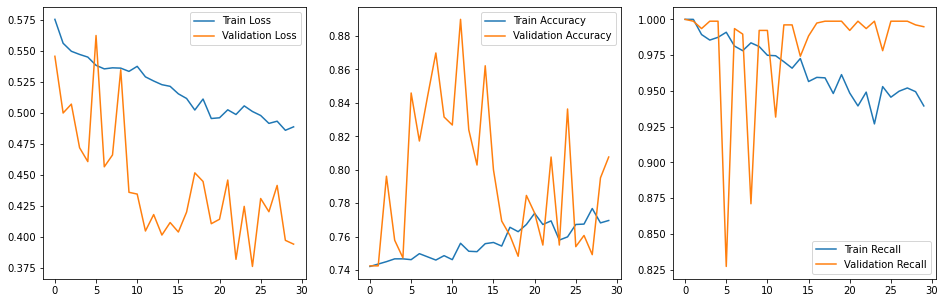

In [95]:
cnn_train_loss = cnn_results.history['loss']
cnn_train_acc = cnn_results.history['accuracy']
cnn_train_rec = cnn_results.history['recall']
cnn_val_loss = cnn_results.history['val_loss']
cnn_val_acc = cnn_results.history['val_accuracy']
cnn_val_rec = cnn_results.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=cnn_train_loss, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=cnn_train_acc, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=cnn_train_rec, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=cnn_val_loss, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=cnn_val_acc, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=cnn_val_rec, ax=ax3, label='Validation Recall')

### CNN w/o Augmented

In [98]:
cnn_model1 = Sequential()
cnn_model1.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model1.add(MaxPooling2D(pool_size=(2,2)))
cnn_model1.add(Conv2D(64, (3,3), activation='relu'))
cnn_model1.add(MaxPooling2D((2,2)))
cnn_model1.add(Flatten())
cnn_model1.add(Dense(64, activation='relu'))
cnn_model1.add(Dense(1, activation='sigmoid'))
              
cnn_model1.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results1 = cnn_model1.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 228ms/step - loss: 0.2812 - accuracy: 0.8798 - recall: 0.9640 - val_loss: 0.0921 - val_accuracy: 0.9703 - val_recall: 0.9755
Epoch 2/30
131/131 [==============================] - 29s 225ms/step - loss: 0.1322 - accuracy: 0.9496 - recall: 0.9685 - val_loss: 0.1059 - val_accuracy: 0.9608 - val_recall: 0.9523
Epoch 3/30
131/131 [==============================] - 29s 223ms/step - loss: 0.1058 - accuracy: 0.9620 - recall: 0.9762 - val_loss: 0.0924 - val_accuracy: 0.9589 - val_recall: 0.9549
Epoch 4/30
131/131 [==============================] - 29s 222ms/step - loss: 0.0940 - accuracy: 0.9634 - recall: 0.9765 - val_loss: 0.0837 - val_accuracy: 0.9646 - val_recall: 0.9613
Epoch 5/30
131/131 [==============================] - 30s 229ms/step - loss: 0.0795 - accuracy: 0.9699 - recall: 0.9804 - val_loss: 0.0815 - val_accuracy: 0.9646 - val_recall: 0.9923
Epoch 6/30
131/131 [==============================] - 29s 225ms/step - loss: 0.0640 -

In [99]:
cnn_model1.evaluate(validation_set)

33/33 [==============================] - 5s 159ms/step - loss: 0.1297 - accuracy: 0.9789 - recall: 0.9871


[0.12965843081474304, 0.9789473414421082, 0.9871134161949158]

<AxesSubplot:>

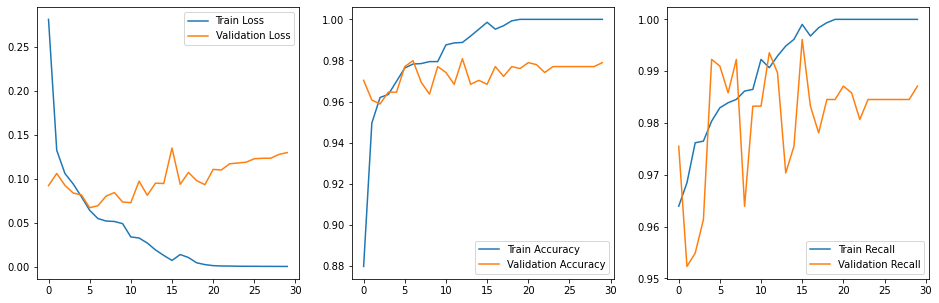

In [104]:
cnn_train_loss1 = cnn_results1.history['loss']
cnn_train_acc1 = cnn_results1.history['accuracy']
cnn_train_rec1 = cnn_results1.history['recall']
cnn_val_loss1 = cnn_results1.history['val_loss']
cnn_val_acc1 = cnn_results1.history['val_accuracy']
cnn_val_rec1 = cnn_results1.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=cnn_train_loss1, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=cnn_train_acc1, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=cnn_train_rec1, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=cnn_val_loss1, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=cnn_val_acc1, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=cnn_val_rec1, ax=ax3, label='Validation Recall')

### 2nd CNN w/o augmentation

In [106]:
cnn_model2 = Sequential()
cnn_model2.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))
cnn_model2.add(Conv2D(64, (3,3), activation='relu'))
cnn_model2.add(MaxPooling2D((2,2)))
cnn_model2.add(Dropout(0.2))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(64, activation='relu'))
cnn_model2.add(Dense(1, activation='sigmoid'))
              
cnn_model2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results2 = cnn_model2.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 29s 223ms/step - loss: 0.2857 - accuracy: 0.8813 - recall: 0.9649 - val_loss: 0.1378 - val_accuracy: 0.9579 - val_recall: 0.9536
Epoch 2/30
131/131 [==============================] - 29s 218ms/step - loss: 0.1286 - accuracy: 0.9498 - recall: 0.9675 - val_loss: 0.1105 - val_accuracy: 0.9579 - val_recall: 0.9910
Epoch 3/30
131/131 [==============================] - 29s 218ms/step - loss: 0.1020 - accuracy: 0.9591 - recall: 0.9749 - val_loss: 0.0910 - val_accuracy: 0.9656 - val_recall: 0.9936
Epoch 4/30
131/131 [==============================] - 28s 217ms/step - loss: 0.0910 - accuracy: 0.9632 - recall: 0.9755 - val_loss: 0.0742 - val_accuracy: 0.9770 - val_recall: 0.9910
Epoch 5/30
131/131 [==============================] - 28s 217ms/step - loss: 0.0775 - accuracy: 0.9711 - recall: 0.9804 - val_loss: 0.0661 - val_accuracy: 0.9761 - val_recall: 0.9794
Epoch 6/30
131/131 [==============================] - 29s 218ms/step - loss: 0.0586 -

In [110]:
cnn_model2.evaluate(validation_set)

33/33 [==============================] - 5s 158ms/step - loss: 0.0772 - accuracy: 0.9780 - recall: 0.9820


[0.07715970277786255, 0.977990448474884, 0.9819587469100952]

<AxesSubplot:>

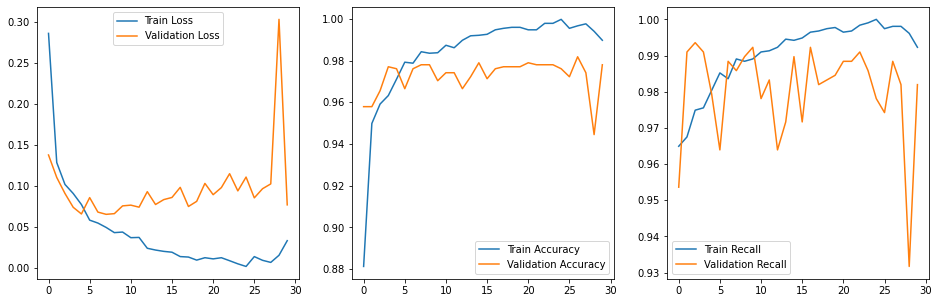

In [107]:
cnn_train_loss2 = cnn_results2.history['loss']
cnn_train_acc2 = cnn_results2.history['accuracy']
cnn_train_rec2 = cnn_results2.history['recall']
cnn_val_loss2 = cnn_results2.history['val_loss']
cnn_val_acc2 = cnn_results2.history['val_accuracy']
cnn_val_rec2 = cnn_results2.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=cnn_train_loss2, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=cnn_train_acc2, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=cnn_train_rec2, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=cnn_val_loss2, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=cnn_val_acc2, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=cnn_val_rec2, ax=ax3, label='Validation Recall')

In [113]:
cnn_model2.evaluate(test_set)

20/20 [==============================] - 3s 152ms/step - loss: 0.8548 - accuracy: 0.8558 - recall: 0.9897


[0.8547819256782532, 0.8557692170143127, 0.9897435903549194]

### 3rd CNN w/o augmentation

In [108]:
cnn_model3 = Sequential()
cnn_model3.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model3.add(MaxPooling2D(pool_size=(2,2)))
cnn_model3.add(Conv2D(64, (3,3), activation='relu'))
cnn_model3.add(MaxPooling2D((2,2)))
cnn_model3.add(Dropout(0.25))
cnn_model3.add(Flatten())
cnn_model3.add(Dense(64, activation='relu'))
cnn_model3.add(Dropout(0.25))
cnn_model3.add(Dense(1, activation='sigmoid'))
              
cnn_model3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results3 = cnn_model3.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 229ms/step - loss: 0.3444 - accuracy: 0.8426 - recall: 0.9723 - val_loss: 0.1381 - val_accuracy: 0.9656 - val_recall: 0.9716
Epoch 2/30
131/131 [==============================] - 29s 223ms/step - loss: 0.1703 - accuracy: 0.9300 - recall: 0.9697 - val_loss: 0.1035 - val_accuracy: 0.9684 - val_recall: 0.9845
Epoch 3/30
131/131 [==============================] - 29s 224ms/step - loss: 0.1474 - accuracy: 0.9429 - recall: 0.9701 - val_loss: 0.1097 - val_accuracy: 0.9694 - val_recall: 0.9781
Epoch 4/30
131/131 [==============================] - 29s 225ms/step - loss: 0.1310 - accuracy: 0.9537 - recall: 0.9768 - val_loss: 0.0867 - val_accuracy: 0.9713 - val_recall: 0.9742
Epoch 5/30
131/131 [==============================] - 29s 224ms/step - loss: 0.1258 - accuracy: 0.9527 - recall: 0.9714 - val_loss: 0.1040 - val_accuracy: 0.9713 - val_recall: 0.9768
Epoch 6/30
131/131 [==============================] - 29s 222ms/step - loss: 0.1147 -

In [111]:
cnn_model3.evaluate(validation_set)

33/33 [==============================] - 5s 160ms/step - loss: 0.1003 - accuracy: 0.9809 - recall: 0.9910


[0.10033038258552551, 0.980861246585846, 0.9909793734550476]

<AxesSubplot:>

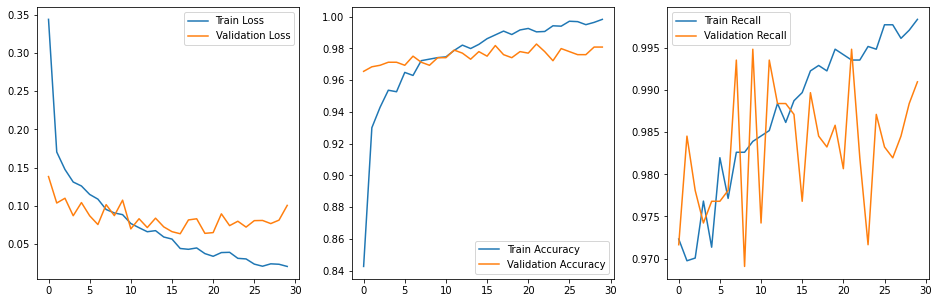

In [109]:
cnn_train_loss3 = cnn_results3.history['loss']
cnn_train_acc3 = cnn_results3.history['accuracy']
cnn_train_rec3 = cnn_results3.history['recall']
cnn_val_loss3 = cnn_results3.history['val_loss']
cnn_val_acc3 = cnn_results3.history['val_accuracy']
cnn_val_rec3 = cnn_results3.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=cnn_train_loss3, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=cnn_train_acc3, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=cnn_train_rec3, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=cnn_val_loss3, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=cnn_val_acc3, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=cnn_val_rec3, ax=ax3, label='Validation Recall')

In [112]:
cnn_model3.evaluate(test_set)

20/20 [==============================] - 3s 154ms/step - loss: 1.3412 - accuracy: 0.8446 - recall: 0.9923


[1.3412182331085205, 0.8445512652397156, 0.9923076629638672]

### Adjusting Adam Learning rate

In [117]:
adam = Adam(learning_rate=.005)

In [118]:
cnn_model4 = Sequential()
cnn_model4.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                       activation='relu',
                       input_shape=(64, 64, 1)))
cnn_model4.add(MaxPooling2D(pool_size=(2,2)))
cnn_model4.add(Conv2D(64, (3,3), activation='relu'))
cnn_model4.add(MaxPooling2D((2,2)))
cnn_model4.add(Dropout(0.25))
cnn_model4.add(Flatten())
cnn_model4.add(Dense(64, activation='relu'))
cnn_model4.add(Dropout(0.25))
cnn_model4.add(Dense(1, activation='sigmoid'))
              
cnn_model4.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(name='recall')])

# fitting to normal train
cnn_results4 = cnn_model4.fit(train_set, epochs=30, validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 30s 227ms/step - loss: 0.4564 - accuracy: 0.7817 - recall: 0.9434 - val_loss: 0.1617 - val_accuracy: 0.9435 - val_recall: 0.9536
Epoch 2/30
131/131 [==============================] - 29s 222ms/step - loss: 0.2224 - accuracy: 0.9016 - recall: 0.9501 - val_loss: 0.1642 - val_accuracy: 0.9407 - val_recall: 0.9884
Epoch 3/30
131/131 [==============================] - 29s 222ms/step - loss: 0.2049 - accuracy: 0.9221 - recall: 0.9411 - val_loss: 0.1184 - val_accuracy: 0.9608 - val_recall: 0.9832
Epoch 4/30
131/131 [==============================] - 29s 222ms/step - loss: 0.1805 - accuracy: 0.9269 - recall: 0.9366 - val_loss: 0.1067 - val_accuracy: 0.9636 - val_recall: 0.9678
Epoch 5/30
131/131 [==============================] - 29s 225ms/step - loss: 0.1708 - accuracy: 0.9374 - recall: 0.9446 - val_loss: 0.1171 - val_accuracy: 0.9627 - val_recall: 0.9910
Epoch 6/30
131/131 [==============================] - 29s 221ms/step - loss: 0.1582 -

<AxesSubplot:>

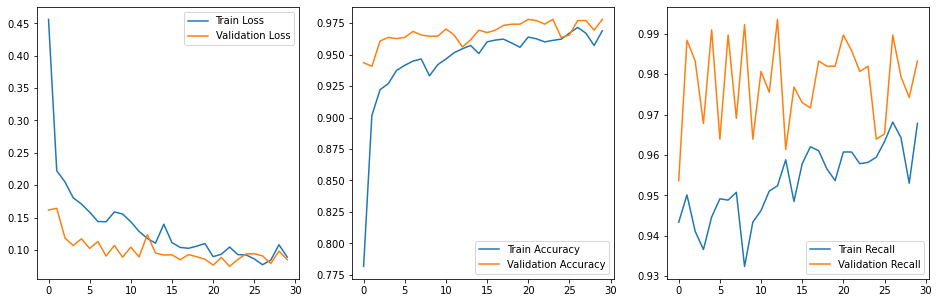

In [119]:
cnn_train_loss4 = cnn_results4.history['loss']
cnn_train_acc4 = cnn_results4.history['accuracy']
cnn_train_rec4 = cnn_results4.history['recall']
cnn_val_loss4 = cnn_results4.history['val_loss']
cnn_val_acc4 = cnn_results4.history['val_accuracy']
cnn_val_rec4 = cnn_results4.history['val_recall']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.lineplot(x=results.epoch, y=cnn_train_loss4, ax=ax1, label='Train Loss')
sns.lineplot(x=results.epoch, y=cnn_train_acc4, ax=ax2, label='Train Accuracy')
sns.lineplot(x=results.epoch, y=cnn_train_rec4, ax=ax3, label='Train Recall')

sns.lineplot(x=results.epoch, y=cnn_val_loss4, ax=ax1, label='Validation Loss')
sns.lineplot(x=results.epoch, y=cnn_val_acc4, ax=ax2, label='Validation Accuracy')
sns.lineplot(x=results.epoch, y=cnn_val_rec4, ax=ax3, label='Validation Recall')

In [120]:
cnn_model4.evaluate(validation_set)

33/33 [==============================] - 5s 159ms/step - loss: 0.0849 - accuracy: 0.9780 - recall: 0.9832


[0.08489663153886795, 0.977990448474884, 0.9832473993301392]

In [121]:
cnn_model4.evaluate(test_set)

20/20 [==============================] - 3s 152ms/step - loss: 1.3172 - accuracy: 0.8734 - recall: 0.9949


[1.3172011375427246, 0.8733974099159241, 0.9948717951774597]